In [1]:
#dependencies
!python -m pip install numpy-stl

In [2]:
#imports
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
from scipy.spatial import Delaunay
from shutil import copyfile

from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
%matplotlib notebook

dataset_random_seed = 0
dataset_size = 50

In [3]:
#generate 2D rectangles - dataset 1
np.random.seed(dataset_random_seed)

def random_rectangle(min_scale, max_scale):
    scale = np.random.rand()*(max_scale-min_scale)+min_scale
    width, height = np.random.rand(2)*scale
    return np.round([0, 0, 0, width, height, width, height, 0],5)

rectangles = list()
for i in range(0,dataset_size):
    rectangles.append(random_rectangle(1,3))
    
with open('dataset_1.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(0,dataset_size):
        csv_writer.writerow(rectangles[i])

In [4]:
#generate 2D convex polygons - dataset 2
np.random.seed(dataset_random_seed)

def random_polygon_convex(min_scale, max_scale, min_vertices, max_vertices):
    n_vertices = np.random.randint(min_vertices,max_vertices)
    scale = np.random.rand()*(max_scale-min_scale)+min_scale
    points = np.random.rand(n_vertices, 2)*scale
    hull = ConvexHull(points)

    vertices = points[hull.vertices,:]
    return np.round(vertices,5)

convex_polygons = list()
for i in range(0,dataset_size):
    convex_polygons.append(random_polygon_convex(1,3,3,12))
    
with open('dataset_2.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(0,dataset_size):
        csv_writer.writerow(convex_polygons[i].flatten())

In [5]:
#generate 2D non-convex polygons - dataset 3
np.random.seed(dataset_random_seed)

def ccw(Ax,Bx,Cx,Ay,By,Cy):
    return (Cy-Ay) * (Bx-Ax) > (By-Ay) * (Cx-Ax)

# Return true if line segments AB and CD intersect
def intersect(Ax,Bx,Cx,Dx, Ay,By,Cy,Dy):
    return ccw(Ax,Cx,Dx,Ay,Cy,Dy) != ccw(Bx,Cx,Dx,By,Cy,Dy) and ccw(Ax,Bx,Cx,Ay,By,Cy) != ccw(Ax,Bx,Dx,Ay,By,Dy)

def count_intersections(vertices):
    n_vertices = vertices.shape[0]
    M=np.zeros((n_vertices,n_vertices))
    vertices = np.vstack((vertices,vertices[0,:]))
    for x in range(0,n_vertices):
        for y in range(x+2,n_vertices):
            M[x,y] = intersect(vertices[x,0],vertices[x+1,0],vertices[y,0],vertices[y+1,0],vertices[x,1],vertices[x+1,1],vertices[y,1],vertices[y+1,1])
    vertices = vertices[0:-1,:]
    return np.sum(M)

def generate_concave_polygon(n_vertices=8):#because of the random part, this is impractical for n_vertices>10
    vertices = np.random.random((n_vertices,2))
    while count_intersections(vertices)>0:
        np.random.shuffle(vertices)
    return vertices

def random_polygon_concave(min_scale, max_scale, min_vertices, max_vertices):
    n_vertices = np.random.randint(min_vertices,max_vertices)
    scale = np.random.rand()*(max_scale-min_scale)+min_scale

    vertices = generate_concave_polygon(n_vertices)*scale
    return np.round(vertices,5)

concave_polygons = list()
for i in range(0,dataset_size):
    concave_polygons.append(random_polygon_concave(1,3,5,10))
    
with open('dataset_3.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(0,dataset_size):
        csv_writer.writerow(concave_polygons[i].flatten())

In [6]:
#dataset 4 is the union of datasets 1, 2, and 3
filenames = ['dataset_1.csv', 'dataset_2.csv', 'dataset_3.csv']
with open('dataset_4.csv', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

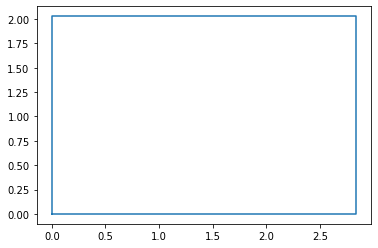

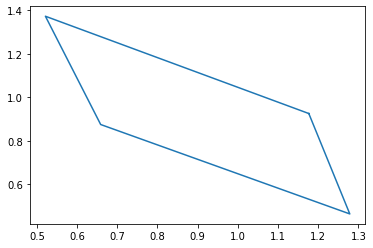

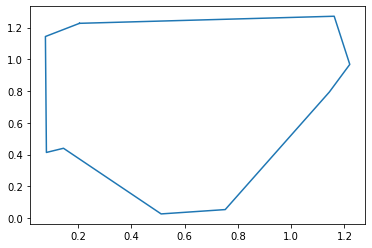

In [7]:
#visualise 2D datasets
vertices = rectangles[49].reshape(4,2)
disp_vertices = np.vstack((vertices,vertices[0,:]))
plt.plot(disp_vertices[:,0],disp_vertices[:,1])
plt.show()
vertices = convex_polygons[49]
disp_vertices = np.vstack((vertices,vertices[0,:]))
plt.plot(disp_vertices[:,0],disp_vertices[:,1])
plt.show()
vertices = concave_polygons[49]
disp_vertices = np.vstack((vertices,vertices[0,:]))
plt.plot(disp_vertices[:,0],disp_vertices[:,1])
plt.show()

In [8]:
#generate 3D cuboids - dataset 5
np.random.seed(dataset_random_seed)

# Define the 12 triangles composing the cuboid (static)
faces = np.array([\
    [0,3,1],
    [1,3,2],
    [0,4,7],
    [0,7,3],
    [4,5,6],
    [4,6,7],
    [5,1,2],
    [5,2,6],
    [2,3,6],
    [3,7,6],
    [0,1,5],
    [0,5,4]])

def random_cuboid(min_scale, max_scale):
    scale = np.random.rand()*(max_scale-min_scale)+min_scale
    width, height, depth = np.round(np.random.rand(3)*scale,5)
    # Define the 8 vertices of the cuboid (dynamic)
    vertices = np.array([\
        [-width, -height, -depth],
        [+width, -height, -depth],
        [+width, +height, -depth],
        [-width, +height, -depth],
        [-width, -height, +depth],
        [+width, -height, +depth],
        [+width, +height, +depth],
        [-width, +height, +depth]])*scale/2
    
    # Create the mesh
    cuboid = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            cuboid.vectors[i][j] = vertices[f[j],:]
    return cuboid
        
for i in range(0,dataset_size):
    cuboid = random_cuboid(1,3)
    cuboid.save('dataset_5/'+str(i)+'.stl')

In [9]:
#generate 3D convex polytopes - dataset 6
np.random.seed(dataset_random_seed)

def generate_convex_polyhedra(min_scale, max_scale, min_vertices, max_vertices):
    scale = np.random.rand()*(max_scale-min_scale)+min_scale
    n_vertices = np.random.randint(min_vertices,max_vertices)

    points = np.round(np.random.rand(n_vertices, 3),5)*scale
    hull = ConvexHull(points)
    return points, hull.simplices

for n in range(0,dataset_size):
    polygon_points, polygon_triangles = generate_convex_polyhedra(1,3,4,15)

    convex_polytope = mesh.Mesh(np.zeros(polygon_triangles.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(polygon_triangles):
        for j in range(3):
            convex_polytope.vectors[i][j] = polygon_points[f[j],:]

    convex_polytope.save('dataset_6/'+str(n)+'.stl')

In [10]:
#generate 3D non-convex polytopes - dataset 7
np.random.seed(dataset_random_seed)

def generate_concave_polyhedra(min_scale, max_scale, min_vertices, max_vertices):
    #first, generate a convex polyhedron
    polygon_points, simplices = generate_convex_polyhedra(1,1,min_vertices,max_vertices)

    #random point inside polytope
    random_point = np.random.rand(3)
    #Delaunay(polygon_points).find_simplex(random_point) >= 0 is True if point lies within poly
    while ~(Delaunay(polygon_points).find_simplex(random_point) >= 0):  # True if point lies within poly
        random_point = np.random.rand(3)

    #select random face
    random_simplex = np.random.randint(0,len(simplices))

    #remove this face, and replace it with three faces between its edges and the random point
    polygon_points = np.concatenate((polygon_points,[random_point]))
    new_point = len(polygon_points)-1

    removed_simplex = simplices[random_simplex]
    simplices = simplices[np.arange(len(simplices))!=random_simplex] #remove the face

    #add three faces
    simplices = np.concatenate((simplices,
          [[removed_simplex[0], removed_simplex[1], new_point],
           [new_point, removed_simplex[1], removed_simplex[2]],
           [removed_simplex[0], new_point, removed_simplex[2]]]))

    scale = np.random.rand()*(max_scale-min_scale)+min_scale
    return np.round(polygon_points*scale,5), simplices


for n in range(0,dataset_size):
    polygon_points, simplices = generate_concave_polyhedra(1,3,4,15)

    concave_polytope = mesh.Mesh(np.zeros(simplices.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(simplices):
        for j in range(3):
            concave_polytope.vectors[i][j] = polygon_points[f[j],:]

    concave_polytope.save('dataset_7/'+str(n)+'.stl')

In [11]:
#dataset 8 is the union of datasets 5, 6, and 7
for d in range(5,8):#dataset number
    for n in range(0,dataset_size):#polytope number
        copyfile('dataset_'+str(d)+'/'+str(n)+'.stl', 'dataset_8/'+str(n+(d-5)*50)+'.stl')

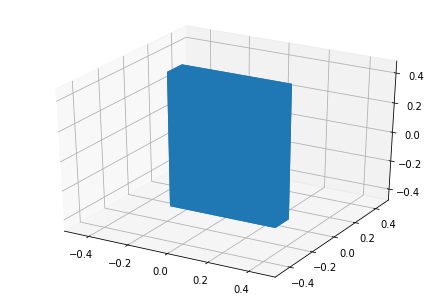

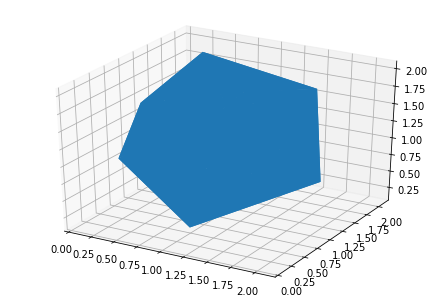

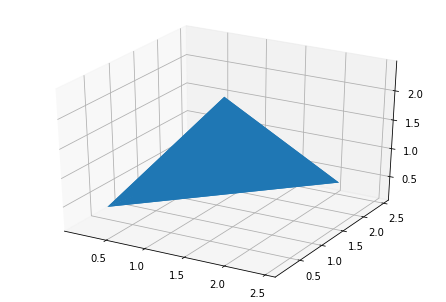

In [13]:
#visualise 3D datasets
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(cuboid.vectors))

scale = cuboid.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

pyplot.show()

figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(convex_polytope.vectors))

scale = convex_polytope.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

pyplot.show()

figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(concave_polytope.vectors))

scale = concave_polytope.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

pyplot.show()